In [28]:
import tensorflow as tf

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

In [16]:
import nltk

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaimeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
stop=set(stopwords.words('english'))

In [25]:
import re
from nltk.tokenize import word_tokenize
import gensim
import string

In [26]:
import keras

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
# from keras.optimizers import Adam

In [36]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [38]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [39]:
tweet.shape

(7613, 5)

In [40]:
test.shape

(3263, 4)

In [41]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [45]:
x = tweet.target.value_counts()

/Users/kaimeng/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

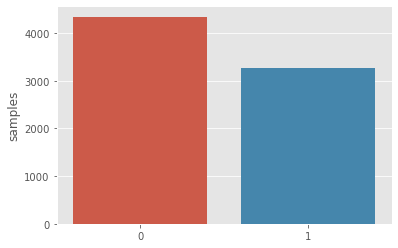

In [48]:
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

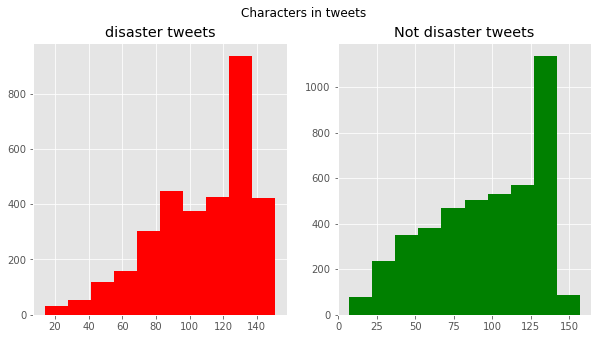

In [51]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

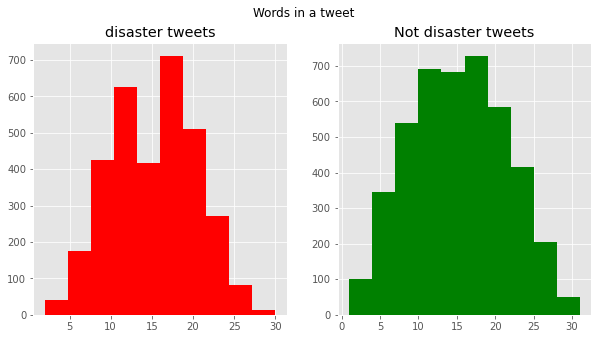

In [52]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [63]:
tweet[tweet['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x]).apply(lambda x: np.mean(x))

0       4.384615
1       4.571429
2       5.090909
3       7.125000
4       4.500000
          ...   
7608    6.636364
7609    5.300000
7610    7.250000
7611    6.263158
7612    6.307692
Name: text, Length: 3271, dtype: float64

/Users/kaimeng/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kaimeng/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

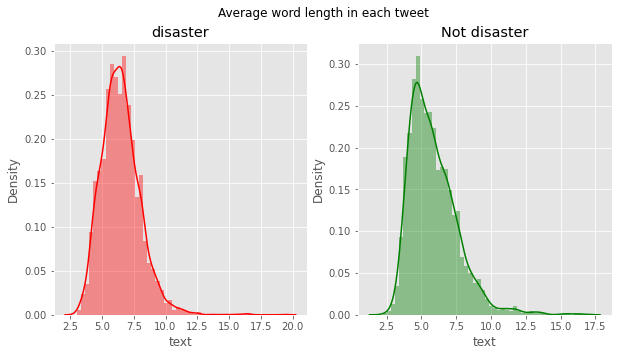

In [64]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [65]:
tweet[tweet['target']==1]['text'].str.split()

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: text, Length: 3271, dtype: object

In [66]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [67]:
corpus=create_corpus(0)

In [74]:
dic=defaultdict(int)

In [75]:
for word in corpus:
    if word in stop:
        dic[word]+=1

In [79]:
top=sorted(dic.items(), key=lambda x: x[1],reverse=True)

In [80]:
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442),
 ('on', 387),
 ('with', 349),
 ('that', 326),
 ('it', 290),
 ('be', 268),
 ('this', 225),
 ('by', 225),
 ('have', 219),
 ('at', 212),
 ('was', 205),
 ('your', 201),
 ('me', 195),
 ('are', 195),
 ('just', 193),
 ('so', 190),
 ('but', 177),
 ('out', 172),
 ('up', 167),
 ('from', 166),
 ('not', 162),
 ('will', 146),
 ('as', 143),
 ('or', 139),
 ('has', 131),
 ('all', 130),
 ('about', 128),
 ('an', 120),
 ('i', 114),
 ('no', 110),
 ('if', 107),
 ('can', 107),
 ('he', 107),
 ('we', 106),
 ('when', 106),
 ('they', 101),
 ('into', 93),
 ('been', 92),
 ('do', 89),
 ("don't", 88),
 ('his', 86),
 ("it's", 85),
 ('her', 82),
 ('what', 81),
 ('how', 76),
 ('more', 73),
 ('now', 73),
 ('after', 66),
 ('who', 61),
 ('some', 55),
 ('there', 55),
 ('had', 53),
 ('our', 51),
 ('their', 51),
 ('over', 51),
 ('off', 51),
 ('should', 50),
 ('than', 50),
 ("you'r

<BarContainer object of 148 artists>

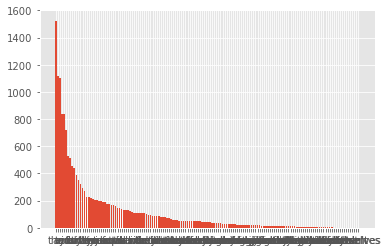

In [81]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

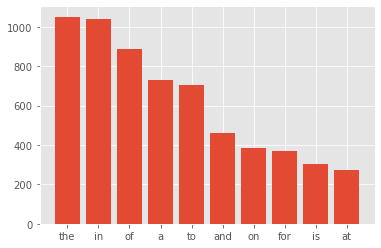

In [82]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

In [84]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

<BarContainer object of 18 artists>

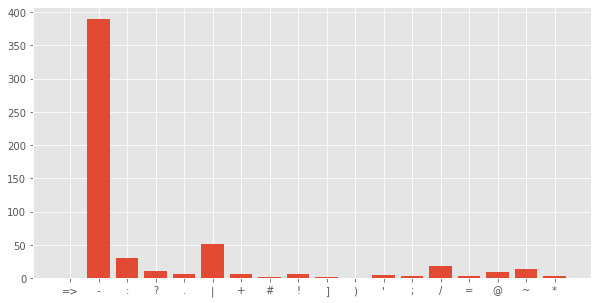

In [85]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [90]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

In [91]:
x

['-',
 'I',
 'The',
 'A',
 'via',
 'fire',
 '...',
 '&amp;',
 'In',
 'California',
 'killed',
 'like']

In [92]:
y

[389, 259, 257, 167, 115, 108, 106, 105, 90, 86, 86, 85]

<AxesSubplot:>

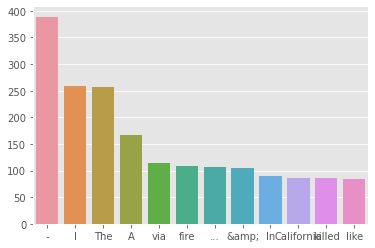

In [94]:
sns.barplot(x=x,y=y)

In [97]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

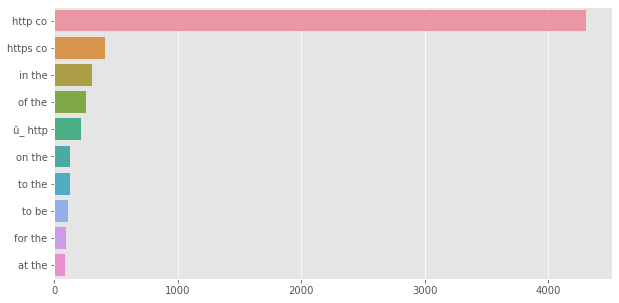

In [98]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [99]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [100]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [101]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [102]:
df['text']=df['text'].apply(lambda x : remove_URL(x))